In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import operator
import collections
from sklearn.model_selection import GridSearchCV

/home/ephlius/.virtualenvs/3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# #############################################################################
# Load data

data = pd.read_csv("HM_cohort_wth_LabTest.csv", index_col=0)
data.loc[:,'leukemia'] = pd.Series(1, index=data.index[data['d_type']=='leukemia'])
data.loc[:,'lymphoma'] = pd.Series(1, index=data.index[data['d_type']=='lymphoma'])
data.loc[:,'myeloma'] = pd.Series(1, index=data.index[data['d_type']=='myeloma'])
data.loc[:,'myelodysplastic_syndrome'] = pd.Series(1, index=data.index[data['d_type']=='myelodysplastic_syndrome'])
data[['p_blood_culture_1', 'rbc_1', 'platelet_1', 'vasopressor_1', 
      'ventilation_1','leukemia','lymphoma','myelodysplastic_syndrome',
      'myeloma']] = data[['p_blood_culture_1', 'rbc_1', 'platelet_1', 'vasopressor_1', 'ventilation_1',
                          'leukemia','lymphoma','myelodysplastic_syndrome','myeloma']].fillna(0)    

df = pd.DataFrame(data, columns =['age', 'sofa','wbc','hemoglobin','platelet','sodium','potassium','creatinine',
                                  'bilirubin',
                                  'ast',
                                  'alt',
                                  'abg_ph', 'abg_pco2', 
                                  #'abg_po2', 
                                  'abg_bicarbonate','abg_baseexcess', 
                                  #'abg_spo2', 
                                  'abg_lactate',
                                  'gender',
                                  'p_blood_culture_1',
                                  'rbc_1', 'platelet_1','ventilation_1','vasopressor_1', 'rrt',
                                  'hypertension', 'congestive_heart_failure', 'cardiac_arrhythmias', 'chronic_pulmonary',
                                  'depression', 'diabetes_uncomplicated', 'hypothyroidism',
                                  'renal_failure', 'rheumatoid_arthritis', 'liver_disease','peptic_ulcer',
                                  #'leukemia','lymphoma','myeloma','myelodysplastic_syndrome',
           
                                  'mort_icu',
                                  'mort_hosp'
                                  
                                ])


df['gender'] = df['gender'].str.replace('M','1')
df['gender'] = df['gender'].str.replace('F','0')
#concert the unit for creatinine from mg/dl to umol/l
df['creatinine']=df['creatinine']*88.42
#df=df.dropna(axis = 0, how='any')
#df=df.fillna(df.median())


mimic_X = pd.DataFrame(df,columns =[
                              'age', 
                              'sofa','wbc','hemoglobin','platelet','sodium','potassium','creatinine',
                              'bilirubin',
                              'ast',
                              'alt',
                              'abg_ph', 'abg_pco2', 
                              #'abg_po2', 
                              'abg_bicarbonate','abg_baseexcess', 
                              #'abg_spo2', 
                              'abg_lactate',
                              'gender',
                              'p_blood_culture_1', 
                              'rbc_1', 
                              'platelet_1','ventilation_1','vasopressor_1', 'rrt',
                              'hypertension', 'congestive_heart_failure', 'cardiac_arrhythmias', 'chronic_pulmonary',
                              'depression', 'diabetes_uncomplicated', 'hypothyroidism',
                              'renal_failure', 'rheumatoid_arthritis', 'liver_disease','peptic_ulcer',
                              #'leukemia','lymphoma','myeloma','myelodysplastic_syndrome'
                                 ])

mimic_y = pd.DataFrame(df,columns =['mort_icu'])
#mimic_y = pd.DataFrame(df,columns =['mort_hosp'])
n_samples, n_features = mimic_X.shape

mimic_X = np.array(mimic_X)
mimic_y = np.ravel(mimic_y)

In [144]:
score =[]
# #############################################################################
# Fit classification model
# use XGboost

params = {'objective':'binary:logistic', 
          
          
          'gamma':0,
          'learning_rate':0.1,
          'min_child_weight':4, 'max_depth':3,
          'n_estimators':430,'nthread':4,
          'reg_lambda':1,'reg_alpha':0.01,
          'scale_pos_weight':1, 'seed':27, 'subsample':0.9,'colsample_bytree':0.7,'scale_pos_weight':1
          }

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(mimic_X):
    X_train, X_test = mimic_X[train_index], mimic_X[test_index]
    y_train, y_test = mimic_y[train_index], mimic_y[test_index]
    classifier = xgb.XGBClassifier(**params)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    score.append(roc_auc.ravel().copy())

score=np.array(score)
print("AUC: %0.3f (+/- %0.3f)" % (score.mean(), score.std()))
print("AUC: %0.3f - %0.3f" % ((score.mean()-score.std()),score.mean()+score.std()))
# split data into train and test sets

test_size = 0.3

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(mimic_X, mimic_y, 
                                                                            test_size=test_size, 
                                                                            random_state=80, shuffle=True)
# fit model no training data
model = xgb.XGBClassifier(**params)
model.fit(X_train_final, y_train_final)
predictions = model.predict(X_test_final)
#ROC curve
#fpr, tpr, thresholds = roc_curve(y_test_final, predictions)
fpr, tpr, _ = roc_curve(y_test_final, predictions)
roc_auc = auc(fpr, tpr)
print("AUC: %0.3f" %roc_auc)

AUC: 0.732 (+/- 0.042)
AUC: 0.690 - 0.774
AUC: 0.811


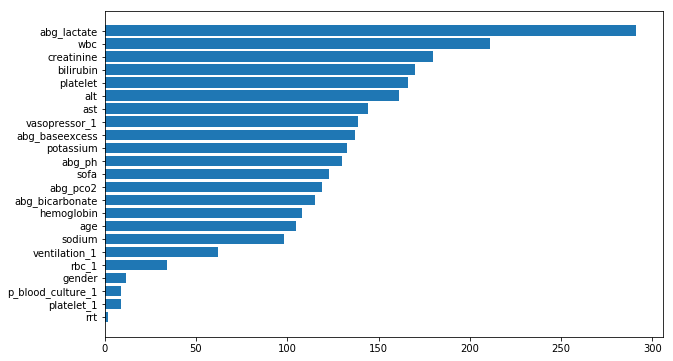

In [77]:
# extract feature importance
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v for k,v in imp_dict.items()}

features_names = ['age', 
                  'sofa','wbc','hemoglobin','platelet','sodium','potassium','creatinine',
                  'bilirubin',
                  'ast', 
                  'alt',
                  'abg_ph', 'abg_pco2', 
                  #'abg_po2', 
                  'abg_bicarbonate','abg_baseexcess',
                  #'abg_spo2', 
                  'abg_lactate',
                  'gender',
                  'p_blood_culture_1',
                  'rbc_1',
                  'platelet_1','ventilation_1','vasopressor_1', 'rrt']
d=get_xgb_imp(model,features_names)
sorted_d= collections.OrderedDict(sorted(d.items(), key=operator.itemgetter(1)))
#plot features importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_d)),sorted_d.values(),align='center')
plt.yticks(range(len(sorted_d)),list(sorted_d.keys()))
plt.show()

In [145]:
auc_score=[]



for i in range(1,2):
    params = {'objective':'binary:logistic', 
          
          
          'gamma':0,
          'learning_rate':0.1,
          'min_child_weight':4, 'max_depth':3,
          'n_estimators':430,'nthread':4,
          'reg_lambda':1,'reg_alpha':0.01,
          'scale_pos_weight':1, 'seed':27, 'subsample':0.9,'colsample_bytree':0.7,'scale_pos_weight':1
          }
    score=[]
    
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(mimic_X):
        X_train, X_test = mimic_X[train_index], mimic_X[test_index]
        y_train, y_test = mimic_y[train_index], mimic_y[test_index]
        classifier = xgb.XGBClassifier(**params)
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, predictions)
        score.append(auc(fpr, tpr).ravel().copy())
    
    score=np.array(score)
    auc_score.append(score.mean()-score1.std())
    
        





np.mean(auc_score)
#AUC: 0.732 (+/- 0.042)
#AUC: 0.690 - 0.774

0.73198700512800108

In [6]:
auc_score=[]



for i in range(1,100):
    score=[]
    params = {'objective':'binary:logistic', 
          
          
          'gamma':0,
          'learning_rate':0.1,
          'min_child_weight':4, 'max_depth':3,
          'n_estimators':430,'nthread':4,
          'reg_lambda':1,'reg_alpha':0.01,
          'scale_pos_weight':1, 'seed':27, 'subsample':0.9,'colsample_bytree':0.7,'scale_pos_weight':1
          }
    
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(mimic_X, mimic_y, 
                                                                            test_size=0.3, 
                                                                            shuffle=True)
    # fit model no training data
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_final, y_train_final)
    predictions = model.predict(X_test_final)
    #ROC curve
    fpr, tpr, _ = roc_curve(y_test_final, predictions)
    score.append(auc(fpr, tpr).ravel().copy())
    score=np.array(score)
    auc_score.append(score.mean())
        





np.mean(auc_score)

0.69734081744583942

In [7]:
np.std(auc_score)

0.040570297372394454